In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function


import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import datetime
import seaborn as sns

#import pydicom
import time
import gc
import operator 
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.utils.data as D
import torch.nn.functional as F
from sklearn.model_selection import KFold
from tqdm import tqdm, tqdm_notebook
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import warnings
warnings.filterwarnings(action='once')
import pickle
%load_ext autoreload
%autoreload 2
%matplotlib inline
from skimage.io import imread,imshow
from helper import *
import helper
import torchvision.models as models
from torch.optim import Adam
from defenitions import *

C:\Users\kiner\Anaconda3\envs\yuvals\lib\site-packages\skimage\__init__.py:71: ResourceWarning: unclosed file <_io.TextIOWrapper name='C:\\Users\\kiner\\Anaconda3\\envs\\yuvals\\lib\\site-packages\\pytest.py' mode='r' encoding='utf-8'>
  imp.find_module('pytest')
C:\Users\kiner\Anaconda3\envs\yuvals\lib\importlib\_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
C:\Users\kiner\Anaconda3\envs\yuvals\lib\importlib\_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


In [2]:
SEED = 22428429
#device=device_by_name("Tesla")
device=device_by_name("1060")
torch.cuda.set_device(device)
#device = "cpu"
sendmeemail=Email_Progress(my_gmail,my_pass,to_email,'Densenet161-Copy2-2 results')

In [3]:
def get_submission(test_df,pred):
    epidural_df=pd.DataFrame(data={'ID':'ID_'+test_df.PatientID.values+'_epidural','Label':torch.sigmoid(pred[:,0])})
    intraparenchymal_df=pd.DataFrame(data={'ID':'ID_'+test_df.PatientID.values+'_intraparenchymal','Label':torch.sigmoid(pred[:,1])})
    intraventricular_df=pd.DataFrame(data={'ID':'ID_'+test_df.PatientID.values+'_intraventricular','Label':torch.sigmoid(pred[:,2])})
    subarachnoid_df=pd.DataFrame(data={'ID':'ID_'+test_df.PatientID.values+'_subarachnoid','Label':torch.sigmoid(pred[:,3])})
    subdural_df=pd.DataFrame(data={'ID':'ID_'+test_df.PatientID.values+'_subdural','Label':torch.sigmoid(pred[:,4])})
    any_df=pd.DataFrame(data={'ID':'ID_'+test_df.PatientID.values+'_any','Label':torch.sigmoid(pred[:,5])}) 
    return pd.concat([epidural_df,
                        intraparenchymal_df,
                        intraventricular_df,
                        subarachnoid_df,
                        subdural_df,
                        any_df]).sort_values('ID').reset_index(drop=True)

In [4]:
def get_submission_ids(image_ids,pred):
    epidural_df=pd.DataFrame(data={'ID':'ID_'+image_ids+'_epidural','Label':torch.sigmoid(pred[:,0])})
    intraparenchymal_df=pd.DataFrame(data={'ID':'ID_'+image_ids+'_intraparenchymal','Label':torch.sigmoid(pred[:,1])})
    intraventricular_df=pd.DataFrame(data={'ID':'ID_'+image_ids+'_intraventricular','Label':torch.sigmoid(pred[:,2])})
    subarachnoid_df=pd.DataFrame(data={'ID':'ID_'+image_ids+'_subarachnoid','Label':torch.sigmoid(pred[:,3])})
    subdural_df=pd.DataFrame(data={'ID':'ID_'+image_ids+'_subdural','Label':torch.sigmoid(pred[:,4])})
    any_df=pd.DataFrame(data={'ID':'ID_'+image_ids+'_any','Label':torch.sigmoid(pred[:,5])}) 
    return pd.concat([epidural_df,
                        intraparenchymal_df,
                        intraventricular_df,
                        subarachnoid_df,
                        subdural_df,
                        any_df]).sort_values('ID').reset_index(drop=True)

In [5]:
train_df = pd.read_csv(data_dir+'train.csv')
train_df=train_df[~train_df.PatientID.isin(bad_images)].reset_index(drop=True)
train_df.head()
train_df.shape

,PatientID,epidural,intraparenchymal,intraventricular,subarachnoid,subdural,any,PID,StudyI,SeriesI,WindowCenter,WindowWidth,ImagePositionZ,ImagePositionX,ImagePositionY
0,63eb1e259,0,0,0,0,0,0,a449357f,62d125e5b2,0be5c0d1b3,"['00036', '00036']","['00080', '00080']",180.199951,-125.0,-8.000000
1,2669954a7,0,0,0,0,0,0,363d5865,a20b80c7bf,3564d584db,"['00047', '00047']","['00080', '00080']",922.530821,-156.0,45.572849
2,52c9913b1,0,0,0,0,0,0,9c2b4bd7,3e3634f8cf,973274ffc9,40,150,4.455000,-125.0,-115.063000
3,4e6ff6126,0,0,0,0,0,0,3ae81c2d,a1390c15c2,e5ccad8244,"['00036', '00036']","['00080', '00080']",100.000000,-99.5,28.500000
4,7858edd88,0,0,0,0,0,0,c1867feb,c73e81ed3a,28e0531b3a,40,100,145.793000,-125.0,-132.190000


(674504, 15)

C:\Users\kiner\Anaconda3\envs\yuvals\lib\site-packages\_pytest\fixtures.py:844: DeprecationWarning: The `convert` argument is deprecated in favor of `converter`.  It will be removed after 2019/01.
  params = attr.ib(convert=attr.converters.optional(tuple))


In [6]:
test_df = pd.read_csv(data_dir+'test.csv')
test_df.head()

,PatientID,epidural,intraparenchymal,intraventricular,subarachnoid,subdural,any,SeriesI,PID,StudyI,WindowCenter,WindowWidth,ImagePositionZ,ImagePositionX,ImagePositionY
0,28fbab7eb,0.5,0.5,0.5,0.5,0.5,0.5,ebfd7e4506,cf1b6b11,93407cadbb,30,80,158.458000,-125.0,-135.598000
1,877923b8b,0.5,0.5,0.5,0.5,0.5,0.5,6d95084e15,ad8ea58f,a337baa067,30,80,138.729050,-125.0,-101.797981
2,a591477cb,0.5,0.5,0.5,0.5,0.5,0.5,8e06b2c9e0,ecfb278b,0cfe838d54,30,80,60.830002,-125.0,-133.300003
3,42217c898,0.5,0.5,0.5,0.5,0.5,0.5,e800f419cf,e96e31f4,c497ac5bad,30,80,55.388000,-125.0,-146.081000
4,a130c4d2f,0.5,0.5,0.5,0.5,0.5,0.5,faeb7454f3,69affa42,854e4fbc01,30,80,33.516888,-125.0,-118.689819


In [7]:
dup=train_df.duplicated()

In [8]:
train_df=train_df[~dup]

In [9]:
train_df=train_df.reset_index(drop=True)

In [10]:
train_df.shape

(674252, 15)

In [11]:
split = train_df.SeriesI.unique()
np.random.seed(SEED)
np.random.shuffle(split)
split_train=split[:int(0.9*split.shape[0])]
split_val=split[int(0.9*split.shape[0]):]

#idx_train = train_df.drop_duplicates()[train_df.drop_duplicates().SeriesI.isin(set(split_train))].index.values
#idx_validate = train_df.drop_duplicates()[train_df.drop_duplicates().SeriesI.isin(set(split_val))].index.values
#idx_train.shape
#idx_validate.shape

In [12]:
def my_loss(y_pred,y_true,weights):
    window=(y_true>=0).to(torch.float)
    loss = (F.binary_cross_entropy_with_logits(y_pred,y_true,reduction='none')*window*weights.expand_as(y_true)).mean()
    return loss

In [13]:
class Metric():
    def __init__(self,weights,k=0.03):
        self.weights=weights
        self.k=k
        self.zero()
        
    def zero(self):
        self.loss_sum=0.
        self.loss_count=0.
        self.lossf=0.
        
    def calc(self,y_pred,y_true,prefix=""):
        window=(y_true>=0).to(torch.float)
        loss = (F.binary_cross_entropy_with_logits(y_pred,y_true,reduction='none')*window*self.weights.expand_as(y_true)).mean()/(window.mean()+1e-5)
        self.lossf=self.lossf*(1-self.k)+loss*self.k
        self.loss_sum=self.loss_sum+loss*window.sum()
        self.loss_count=self.loss_count+window.sum()
        return({prefix+'mloss':self.lossf})    
        
    def calc_sums(self,prefix=""):
        return({prefix+'mloss_tot':self.loss_sum/self.loss_count})    



In [14]:
%matplotlib nbagg
num_neighbors=2
model_name,version, num_split = 'Densenet161_3' , 'basic_classifier_wso2',2
pickle_file=open(outputs_dir+outputs_format.format(model_name,version,'features_train_tta',num_split),'rb')
features=pickle.load(pickle_file)
pickle_file.close()
features.shape

torch.Size([2698016, 552])

In [15]:
features=features.reshape(features.shape[0]//4,4,-1)
features.shape

torch.Size([674504, 4, 552])

In [16]:
features=features[np.where(~dup)]
features.shape[0]

674252

In [17]:
#features=(features-features.mean())/features.std()

In [18]:
class SimpleModel(nn.Module):
    def __init__(self,in_size):
        super(SimpleModel, self).__init__()
        self.dont_do_grad=[]
        self.conv2d1=torch.nn.Conv2d(1, 128, (7,in_size), padding=(3,0))
        self.bn0=torch.nn.BatchNorm1d(128)
        self.relu0=torch.nn.ReLU()
        self.conv1d1=torch.nn.Conv1d(128, 128, 5, padding=2)
        self.bn1=torch.nn.BatchNorm1d(128)
        self.relu1=torch.nn.ReLU()
        self.conv1d2=torch.nn.Conv1d(128, 64, 3, padding=1)
        self.bn2=torch.nn.BatchNorm1d(64)
        self.relu2=torch.nn.ReLU()
        self.conv1d3=torch.nn.Conv1d(64, 6, 3, padding=1)
        
        
    def forward(self, x):
        x = self.conv2d1(x.unsqueeze(1)).squeeze(-1)
        x = self.bn0(x)
        x = self.relu0(x)
        x = self.conv1d1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.conv1d2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        out = self.conv1d3(x).transpose(-1,-2)
        return out 
                    
    def no_grad(self):
        for param in self.parameters():
            param.requires_grad=False

    def do_grad(self):
        for n,p in self.named_parameters():
            p.requires_grad=  not any(nd in n for nd in self.dont_do_grad)


In [19]:
class BaseModel(nn.Module):
    def __init__(self):
        super(BaseModel, self).__init__()
        self.dont_do_grad=[]
        self.conv2d1=torch.nn.Conv2d(1, 128, (5,2208), padding=(2,0))
        self.relu0=torch.nn.ReLU()
        self.conv1d1=torch.nn.Conv1d(128, 6, 1)

        
        
    def forward(self, x):
        x = self.conv2d1(x.unsqueeze(1)).squeeze(-1)
        x = self.relu0(x)
        out = self.conv1d1(x).transpose(-1,-2)
        return out 
                    
    def no_grad(self):
        for param in self.parameters():
            param.requires_grad=False

    def do_grad(self):
        for n,p in self.named_parameters():
            p.requires_grad=  not any(nd in n for nd in self.dont_do_grad)


In [20]:
np.random.seed(SEED+num_split)
torch.manual_seed(SEED+num_split)
torch.cuda.manual_seed(SEED+num_split)
torch.backends.cudnn.deterministic = True
klr=1
batch_size=16
num_workers=1

#model0 = MyDenseNet(models.densenet161(pretrained=True),len(hemorrhage_types),num_channels=3)
#model0.load_state_dict(torch.load(models_dir+models_format.format(model_name,version,num_split),map_location=torch.device(device)))
#_=model0.to('cpu')
weights = torch.tensor([1.,1.,1.,1.,1.,2.],device=device)
train_dataset=FullHeadDataset(train_df,
                              split_train,
                              features,
                              'SeriesI',
                              'ImagePositionZ',
                              hemorrhage_types)                
validate_dataset=FullHeadDataset(train_df,
                                 split_val,
                                 features[:,0,:],
                                 'SeriesI',
                                 'ImagePositionZ',
                                 hemorrhage_types)                

<IPython.core.display.Javascript object>


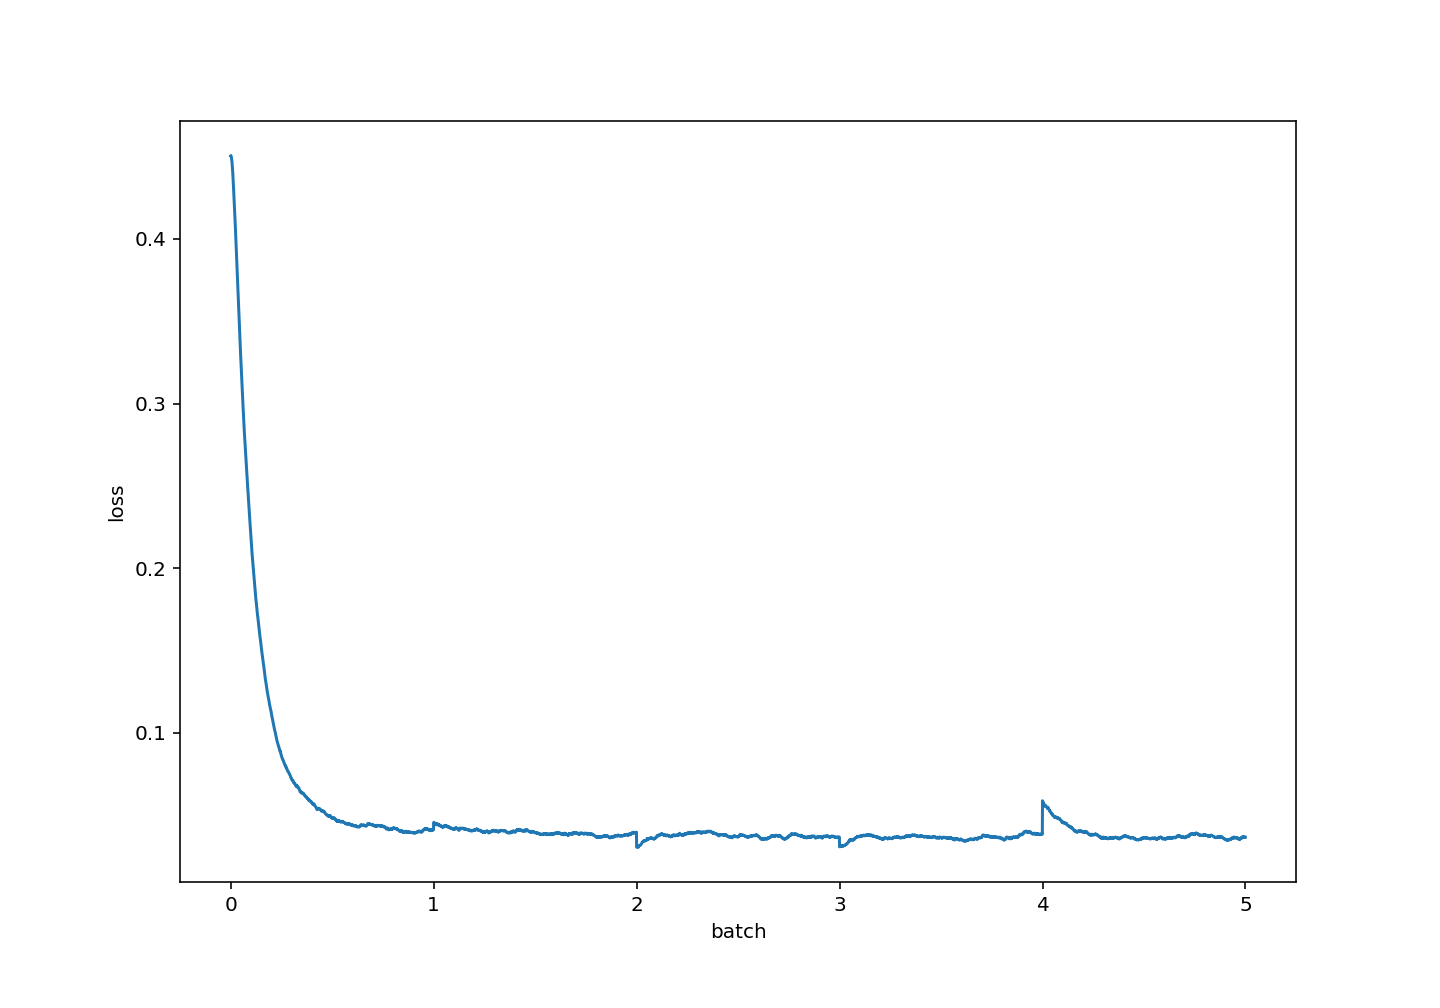

HBox(children=(IntProgress(value=0, max=5), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1099), HTML(value='')))

HBox(children=(IntProgress(value=0, max=123), HTML(value='')))

{'loss': 0.04108926303675201, 'mloss': tensor(0.0722), 'val_loss': 0.04071193413309208, 'val_mloss_tot': tensor(0.0709)}


HBox(children=(IntProgress(value=0, max=1099), HTML(value='')))

HBox(children=(IntProgress(value=0, max=123), HTML(value='')))

{'loss': 0.03961985480489542, 'mloss': tensor(0.0721), 'val_loss': 0.04092599980048532, 'val_mloss_tot': tensor(0.0711)}


HBox(children=(IntProgress(value=0, max=1099), HTML(value='')))

HBox(children=(IntProgress(value=0, max=123), HTML(value='')))

{'loss': 0.0365982612463014, 'mloss': tensor(0.0636), 'val_loss': 0.038662938491963755, 'val_mloss_tot': tensor(0.0673)}


HBox(children=(IntProgress(value=0, max=1099), HTML(value='')))

HBox(children=(IntProgress(value=0, max=123), HTML(value='')))

{'loss': 0.038385686651213065, 'mloss': tensor(0.0658), 'val_loss': 0.03901811892439316, 'val_mloss_tot': tensor(0.0678)}


HBox(children=(IntProgress(value=0, max=1099), HTML(value='')))

HBox(children=(IntProgress(value=0, max=123), HTML(value='')))

{'loss': 0.036631967330602797, 'mloss': tensor(0.0652), 'val_loss': 0.03918820795247225, 'val_mloss_tot': tensor(0.0682)}

0.038662938491963755


In [21]:
model=SimpleModel(2208//4)
num_epochs=5
version='basic_classifier_wso2_tta'+'_fullhead'
_=model.to(device)

loss_func=my_loss
fig,ax = plt.subplots(figsize=(10,7))
gr=loss_graph(fig,ax,num_epochs,len(train_dataset)//batch_size+1)
#num_train_optimization_steps = num_epochs*(sample_ratio*len(train_dataset)//batch_size+int(len(train_dataset)%batch_size>0))
#sched=WarmupExpCosineWithWarmupRestartsSchedule( t_total=num_train_optimization_steps, cycles=num_epochs,tau=0)
param_optimizer = model.parameters()
optimizer = torch.optim.Adam(param_optimizer, lr=0.001)
history,best_model= model_train(model,
                                optimizer,
                                train_dataset,
                                batch_size,
                                num_epochs,
                                loss_func,
                                weights=weights,
                                do_apex=False,
                                validate_dataset=validate_dataset,
                                param_schedualer=None,
                                weights_data=None,
                                metric=Metric(torch.tensor([1.,1.,1.,1.,1.,2.])),
                                return_model=True,
                                num_workers=num_workers,
                                sampler=None,
                                graph=gr)
torch.save(best_model.state_dict(), models_dir+models_format.format(model_name,version,num_split))

<IPython.core.display.Javascript object>


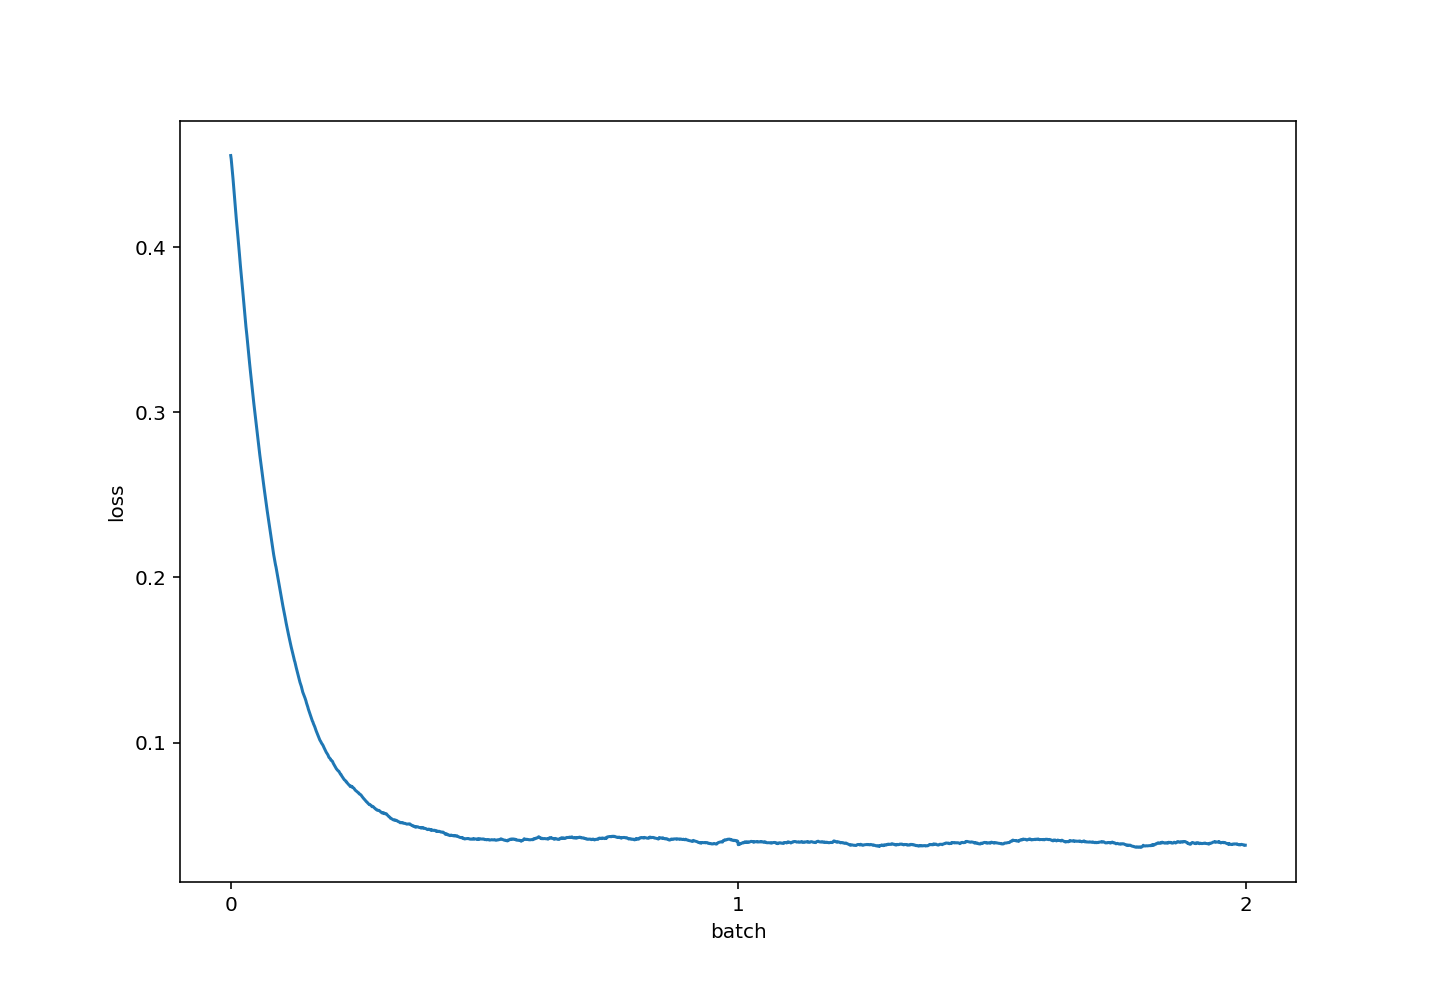

HBox(children=(IntProgress(value=0, max=2), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1099), HTML(value='')))

HBox(children=(IntProgress(value=0, max=123), HTML(value='')))

{'loss': 0.04027447080312164, 'mloss': tensor(0.0698), 'val_loss': 0.03991024229463523, 'val_mloss_tot': tensor(0.0695)}


HBox(children=(IntProgress(value=0, max=1099), HTML(value='')))

HBox(children=(IntProgress(value=0, max=123), HTML(value='')))

{'loss': 0.037909025050536185, 'mloss': tensor(0.0636), 'val_loss': 0.039747592008755946, 'val_mloss_tot': tensor(0.0692)}
0.039747592008755946


In [32]:
model=BaseModel()
num_epochs=2
version='basic_classifier'+'_fullhead'
_=model.to(device)

loss_func=my_loss
fig,ax = plt.subplots(figsize=(10,7))
gr=loss_graph(fig,ax,num_epochs,len(train_dataset)//batch_size+1)
#num_train_optimization_steps = num_epochs*(sample_ratio*len(train_dataset)//batch_size+int(len(train_dataset)%batch_size>0))
#sched=WarmupExpCosineWithWarmupRestartsSchedule( t_total=num_train_optimization_steps, cycles=num_epochs,tau=0)
param_optimizer = model.parameters()
optimizer = torch.optim.Adam(param_optimizer, lr=0.001)
history,best_model= model_train(model,
                                optimizer,
                                train_dataset,
                                batch_size,
                                num_epochs,
                                loss_func,
                                weights=weights,
                                do_apex=False,
                                validate_dataset=validate_dataset,
                                param_schedualer=None,
                                weights_data=None,
                                metric=Metric(torch.tensor([1.,1.,1.,1.,1.,2.])),
                                return_model=True,
                                num_workers=num_workers,
                                sampler=None,
                                graph=gr)
torch.save(best_model.state_dict(), models_dir+models_format.format(model_name,version,num_split))

<IPython.core.display.Javascript object>


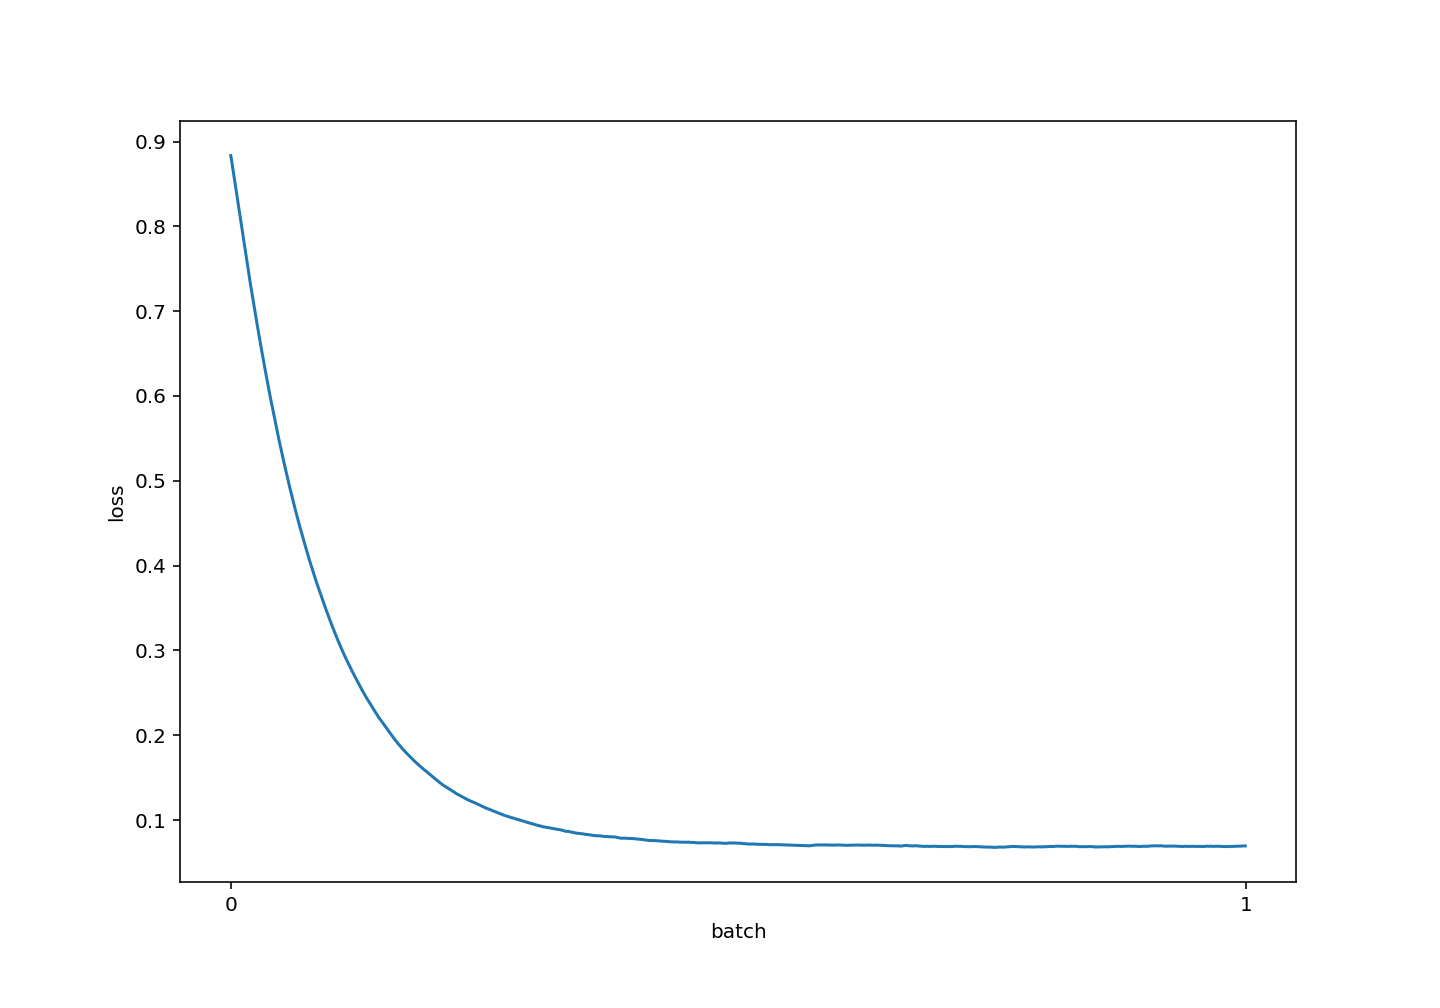

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1186), HTML(value='')))

HBox(children=(IntProgress(value=0, max=132), HTML(value='')))

{'loss': 0.06941890306640373, 'val_loss': 0.07025640195404942}

0.07025640195404942


In [17]:
idx_train = train_df[train_df.SeriesI.isin(set(split_train))].index.values
idx_validate = train_df[train_df.SeriesI.isin(set(split_val))].index.values

np.random.seed(SEED+num_split)
torch.manual_seed(SEED+num_split)
torch.cuda.manual_seed(SEED+num_split)
torch.backends.cudnn.deterministic = True
klr=1
batch_size=512
num_workers=1
num_epochs=1
#model0 = MyDenseNet(models.densenet161(pretrained=True),len(hemorrhage_types),num_channels=3)
#model0.load_state_dict(torch.load(models_dir+models_format.format(model_name,version,num_split),map_location=torch.device(device)))
#_=model0.to('cpu')
model=NeighborsNet(len(hemorrhage_types),
                   num_neighbors=num_neighbors,
                   num_features=2208,
                   intermidiate=128, 
                   dropout=0.5)


version=version+'_neighbors{}'.format(num_neighbors)
_=model.to(device)
weights = torch.tensor([1.,1.,1.,1.,1.,2.],device=device)
loss_func=my_loss
param_optimizer = model.parameters()
features_dataset=FeatursDataset(train_df,features,num_neighbors,'SeriesI','ImagePositionZ',hemorrhage_types)
train_dataset=D.Subset(features_dataset,idx_train)
validate_dataset=D.Subset(features_dataset,idx_validate)
fig,ax = plt.subplots(figsize=(10,7))
gr=loss_graph(fig,ax,num_epochs,len(train_dataset)//batch_size+1)
#num_train_optimization_steps = num_epochs*(sample_ratio*len(train_dataset)//batch_size+int(len(train_dataset)%batch_size>0))
#sched=WarmupExpCosineWithWarmupRestartsSchedule( t_total=num_train_optimization_steps, cycles=num_epochs,tau=0)
optimizer = torch.optim.Adam(param_optimizer, lr=0.001)
history,best_model= model_train(model,
                                optimizer,
                                train_dataset,
                                batch_size,
                                num_epochs,
                                loss_func,
                                weights=weights,
                                do_apex=False,
                                validate_dataset=validate_dataset,
                                param_schedualer=None,
                                weights_data=None,
                                metric=None,
                                return_model=True,
                                num_workers=num_workers,
                                sampler=None,
                                graph=gr)
torch.save(best_model.state_dict(), models_dir+models_format.format(model_name,version,num_split))

In [30]:
num_neighbors=2
model_name,version, num_split = 'Densenet161_3' , 'basic_classifier_wso2',2
pickle_file=open(outputs_dir+outputs_format.format(model_name,version,'features_test_tta',num_split),'rb')
features=pickle.load(pickle_file)
pickle_file.close()
features=features.reshape(features.shape[0]//8,8,-1)
version=version+'_tta_fullhead'
model=SimpleModel(2208//4)

model.load_state_dict(torch.load(models_dir+models_format.format(model_name,version,num_split),map_location=torch.device(device)))
test_dataset=train_dataset=FullHeadDataset(test_df,
                              test_df.SeriesI.unique(),
                              features,
                              'SeriesI',
                              'ImagePositionZ')
pred_list=[]
for i in tqdm_notebook(range(8)):
    pred_list.append(model_run(model,test_dataset,do_apex=False,batch_size=64)[...,None])

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

HBox(children=(IntProgress(value=0, max=8), HTML(value='')))

HBox(children=(IntProgress(value=0, max=35), HTML(value='')))

HBox(children=(IntProgress(value=0, max=35), HTML(value='')))

HBox(children=(IntProgress(value=0, max=35), HTML(value='')))

HBox(children=(IntProgress(value=0, max=35), HTML(value='')))

HBox(children=(IntProgress(value=0, max=35), HTML(value='')))

HBox(children=(IntProgress(value=0, max=35), HTML(value='')))

HBox(children=(IntProgress(value=0, max=35), HTML(value='')))

HBox(children=(IntProgress(value=0, max=35), HTML(value='')))

In [31]:
pred=torch.cat(pred_list,-1).mean(-1)

In [32]:
images_id_list=[]
dummeys=[]
image_arr=test_df.PatientID.values
ref_arr=test_df.SeriesI.values
order_arr=test_df.ImagePositionZ.values
for s in tqdm_notebook(test_df.SeriesI.unique()):
    dumm=np.zeros(60)
    head_idx = np.where(ref_arr==s)[0]
    sorted_head_idx=head_idx[np.argsort(order_arr[head_idx])]
    images_id_list.append(image_arr[sorted_head_idx])
    dumm[0:head_idx.shape[0]]=1
    dummeys.append(dumm)
image_ids=np.concatenate(images_id_list)
preds=pred.reshape(pred.shape[0]*pred.shape[1],6).numpy()[np.concatenate(dummeys)==1]

HBox(children=(IntProgress(value=0, max=2214), HTML(value='')))

In [33]:
image_ids.shape

preds.shape

(78545,)

(78545, 6)

In [34]:
submission_df=get_submission_ids(image_ids,torch.tensor(preds))

In [35]:
submission_df.head(20)

,ID,Label
0,ID_000012eaf_any,0.004640
1,ID_000012eaf_epidural,0.000189
2,ID_000012eaf_intraparenchymal,0.000420
3,ID_000012eaf_intraventricular,0.000173
4,ID_000012eaf_subarachnoid,0.001825
5,ID_000012eaf_subdural,0.002255
6,ID_0000ca2f6_any,0.001728
7,ID_0000ca2f6_epidural,0.000111
8,ID_0000ca2f6_intraparenchymal,0.000337
9,ID_0000ca2f6_intraventricular,0.000029


In [36]:
submission_df.head(12)
submission_df.shape
sub_num=27
submission_df.to_csv('E:/RSNA/submission{}.csv'.format(sub_num),
                                                                  index=False, columns=['ID','Label'])

,ID,Label
0,ID_000012eaf_any,0.004640
1,ID_000012eaf_epidural,0.000189
2,ID_000012eaf_intraparenchymal,0.000420
3,ID_000012eaf_intraventricular,0.000173
4,ID_000012eaf_subarachnoid,0.001825
5,ID_000012eaf_subdural,0.002255
6,ID_0000ca2f6_any,0.001728
7,ID_0000ca2f6_epidural,0.000111
8,ID_0000ca2f6_intraparenchymal,0.000337
9,ID_0000ca2f6_intraventricular,0.000029


(471270, 2)

In [43]:
num_neighbors=2
model_name,version, num_split = 'Densenet161_3' , 'basic_classifier',2
pickle_file=open(outputs_dir+outputs_format.format(model_name,version,'features_test',num_split),'rb')
features=pickle.load(pickle_file)
pickle_file.close()
version=version+'_fullhead'
model=SimpleModel(features.shape[-1])

model.load_state_dict(torch.load(models_dir+models_format.format(model_name,version,num_split),map_location=torch.device(device)))
test_dataset=train_dataset=FullHeadDataset(test_df,
                              test_df.SeriesI.unique(),
                              features,
                              'SeriesI',
                              'ImagePositionZ')
pred = model_run(model,test_dataset,do_apex=False,batch_size=64)

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

HBox(children=(IntProgress(value=0, max=35), HTML(value='')))

In [44]:
images_id_list=[]
dummeys=[]
image_arr=test_df.PatientID.values
ref_arr=test_df.SeriesI.values
order_arr=test_df.ImagePositionZ.values
for s in tqdm_notebook(test_df.SeriesI.unique()):
    dumm=np.zeros(60)
    head_idx = np.where(ref_arr==s)[0]
    sorted_head_idx=head_idx[np.argsort(order_arr[head_idx])]
    images_id_list.append(image_arr[sorted_head_idx])
    dumm[0:head_idx.shape[0]]=1
    dummeys.append(dumm)
image_ids=np.concatenate(images_id_list)
preds1=pred.reshape(pred.shape[0]*pred.shape[1],6).numpy()[np.concatenate(dummeys)==1]

HBox(children=(IntProgress(value=0, max=2214), HTML(value='')))

In [45]:
preds0=preds


In [46]:
preds=(preds0+preds1)/2

In [47]:
submission_df=get_submission_ids(image_ids,torch.tensor(preds))
submission_df.head(12)
submission_df.shape
sub_num=28
submission_df.to_csv('E:/RSNA/submission{}.csv'.format(sub_num),
                                                                  index=False, columns=['ID','Label'])


,ID,Label
0,ID_000012eaf_any,0.004199
1,ID_000012eaf_epidural,0.000201
2,ID_000012eaf_intraparenchymal,0.000525
3,ID_000012eaf_intraventricular,0.000181
4,ID_000012eaf_subarachnoid,0.001289
5,ID_000012eaf_subdural,0.002139
6,ID_0000ca2f6_any,0.001799
7,ID_0000ca2f6_epidural,0.000060
8,ID_0000ca2f6_intraparenchymal,0.000452
9,ID_0000ca2f6_intraventricular,0.000059


(471270, 2)

<IPython.core.display.Javascript object>


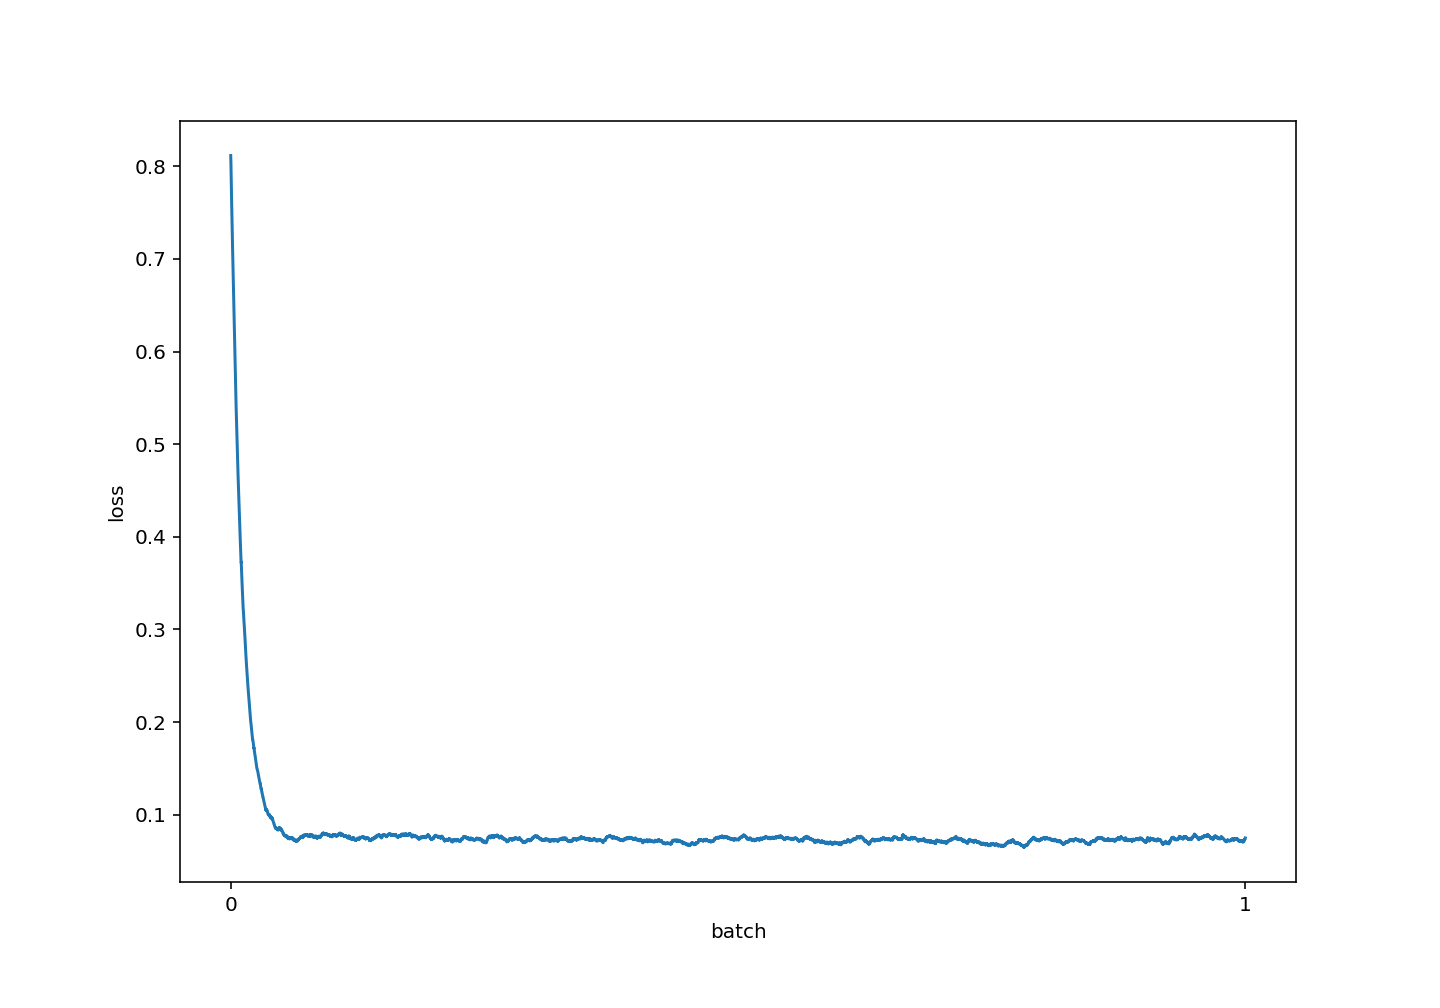

{'loss': 0.0749485937337074, 'val_loss': 0.07314836643778007}
0.07314836643778007


In [15]:
%matplotlib nbagg
num_neighbors=3
model_name,version, num_split = 'Densenet161_3' , 'basic_classifier',2
pickle_file=open(outputs_dir+outputs_format.format(model_name,version,'features_train',num_split),'rb')
features=pickle.load(pickle_file)
pickle_file.close()
np.random.seed(SEED+num_split)
torch.manual_seed(SEED+num_split)
torch.cuda.manual_seed(SEED+num_split)
torch.backends.cudnn.deterministic = True
klr=1
batch_size=64
num_workers=1
num_epochs=1
model0 = MyDenseNet(models.densenet161(pretrained=True),len(hemorrhage_types),num_channels=3)
model0.load_state_dict(torch.load(models_dir+models_format.format(model_name,version,num_split),map_location=torch.device(device)))
_=model0.to('cpu')
model=NeighborsNet(len(hemorrhage_types),
                   num_neighbors=num_neighbors,
                   num_features=model0.classifier.in_features,
                   intermidiate=128, 
                   dropout=0.5)


version=version+'_neighbors{}cor'.format(num_neighbors)
_=model.to(device)
weights = torch.tensor([1.,1.,1.,1.,1.,2.],device=device)
loss_func=my_loss
param_optimizer = model.parameters()
features_dataset=FeatursDatasetCor(train_df,features,num_neighbors,'SeriesI',hemorrhage_types)
train_dataset=D.Subset(features_dataset,idx_train)
validate_dataset=D.Subset(features_dataset,idx_validate)
fig,ax = plt.subplots(figsize=(10,7))
gr=loss_graph(fig,ax,num_epochs,len(train_dataset)//batch_size+1)
#num_train_optimization_steps = num_epochs*(sample_ratio*len(train_dataset)//batch_size+int(len(train_dataset)%batch_size>0))
#sched=WarmupExpCosineWithWarmupRestartsSchedule( t_total=num_train_optimization_steps, cycles=num_epochs,tau=0)
optimizer = torch.optim.Adam(param_optimizer, lr=0.001)
history,best_model= model_train(model,
                                optimizer,
                                train_dataset,
                                batch_size,
                                num_epochs,
                                loss_func,
                                weights=weights,
                                do_apex=False,
                                validate_dataset=validate_dataset,
                                param_schedualer=None,
                                weights_data=None,
                                metric=None,
                                return_model=True,
                                num_workers=num_workers,
                                sampler=None,
                                graph=gr)
torch.save(best_model.state_dict(), models_dir+models_format.format(model_name,version,num_split))